# Classification

## Import Libraries

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier

## Get and View the Data

In [2]:
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'],mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
X = np.asarray(X)

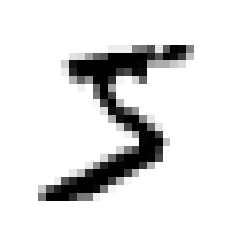

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

We need to convert from a string to an integer.

In [7]:
y = y.astype(np.uint8)

## Train Test Split

The MNIST data is already shuffled such that the first 60000 examples can be taken as train and the rest as test set.

In [8]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

## Training a Binary Classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

Our model seems to be predicting the right class! But we still need to evaluate the model performance in some manner.

## Performance Measures
One good way to evaluate a model is by using cross-validation.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle = True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) #prints 0.9669 0.91625 and 0.96785

0.9669
0.91625
0.96785


The below code achieves the same result.

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

Lets now look at another classifier which always predicts `not 5`.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train,y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

Whoa! A dumb classifier is also able to predict with an accuracy of >0.9! That doesn't bid well for our model whose accuracies are just north of 0.95.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

We can see that 53892 were correctly predicted as `not 5` and 687 were misclassified as `5` (false positives). On the other hand, we have 3530 images were classified as `5` while 1891 were misclassified as `not 5` (false negative).

Let pretend we reached perfection. The confusion matrix would then resemble:

In [18]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives us a lot of information but we may sometimes need a more concise metric. One interesting metric to observe is the accuracy of the positive predictions which is called *precision* of the classifier.

$$precision = \frac{TP}{TP+FP}$$

We could output one correct positive prediction and rest all negative predictions and we would arrive at a precision of 1. But thats not what we want. So there is another metric *recall* which is also called *sensitivity* or *true positive rate (TPR)* which is defined as:
$$recall = \frac{TP}{TP + FN}$$

## Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics including precision and recall

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Notice how our model doesn't look so good now. It achieves a precision score of 83.7% which means that it correctly identifies 5 only ~84% of the time. Moreover it detects only ~65% of the 5s 

It might be convenient to combine precision and recall into a single metric called the F<sub>1</sub> which is basically the harmonic mean of the precision and recall:

$$F1 = \frac{1}{\frac{1}{precision}\frac{1}{recall}}$$
$$F1 = \frac{precision \times recall}{precision + recall}$$

To compute the F1 score simply call the f1_score() function:

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. However, sometimes it is not worth optimising for a high F1 score because sometimes you may want a high precision and are willing to settle for a lower recall in this endeavour. On the other hand, sometimes a high recall may be needed at a cost of lower precision. Unfortunately, for a given model, we can't have it both ways. Increasing precision reduces recall and vice versa.

## Precision/Recall Trade-Off
Refer to `img_2.png` to understand this.

Scikit-Learn does not allow you to set the threshold directly. Instead of calling the `predict()` method, we can call its `decision_function()` method, which returns a score for each instance.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

But how do we even decide which decision function to use? For this we can use the `cross_val_predict` function and specify that we want the `decision_function` and not the prediction.

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold=None):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], 'g--', label = "Recall")
    if threshold!=None:
        plt.axvline(threshold)
        index = (np.abs(thresholds - threshold)).argmin()
        plt.axhline(precisions[index])
        plt.axhline(recalls[index])
    plt.title('Precision and Recall vs Threshold Curves')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.grid()

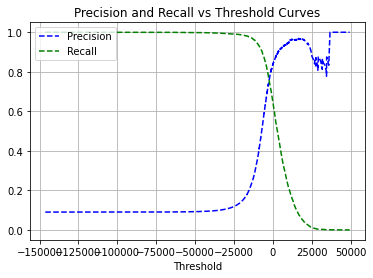

In [65]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another good way to select a good precision-recall trade-off is to plot precision directly against recall.

In [54]:
def plot_precision_vs_recall(precisions, recalls, recall_val = None):
    plt.plot(recalls, precisions, "b--")
    plt.title('Precision vs Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    if recall_val!=None:
        plt.axvline(recall_val)
        index = (np.abs(recalls - recall_val)).argmin()
        plt.axhline(precisions[index])

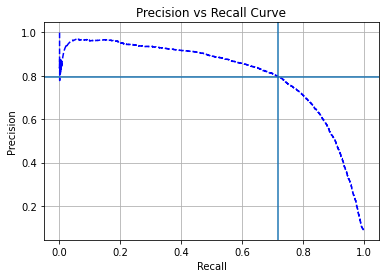

In [63]:
plot_precision_vs_recall(precisions, recalls, 0.72)
plt.show()

We can see that precision starts to fall rapidly at about 0.72 recall value. Looking at the first plot we can see that this corresponds to a threshold of about -2500. To be precise: 

In [66]:
threshold_80_precision = thresholds[np.argmax(precisions >= 0.8)]
threshold_80_precision

-1328.41257665624

In [67]:
y_train_pred_80 = (y_scores >= threshold_80_precision)
precision_score(y_train_5, y_train_pred_80)

0.8

In [68]:
recall_score(y_train_5, y_train_pred_80)

0.7127836192584394

## The ROC Curve

The `receiver operating characteristic` (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the *true positive rate*(recall) vs *false positive rate*. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [77]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, "b--", label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.grid()

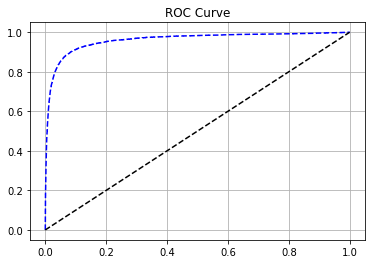

In [74]:
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [75]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top left corner)

Let us now train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to those of the `SGDClassifier`. `RandomForestClassifier` does not have a `decision_function()` method. Instead it has a `predict_proba()` method that we will use

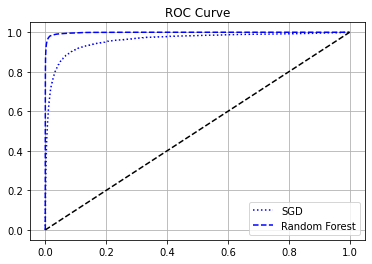

In [78]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest,tpr_forest, "Random Forest")
plt.legend(loc = 'lower right')
plt.show()

In [79]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The ensemble method has improved things a lot!

## Multiclass Classification

Some algorithms
1. SGD
2. Random Forest
3. Naive Bayes

are capable of handling multiple classes natively.<br>
Others

1. Logistic Regression
2. Support Vector Machine
are strictly binary classifiers.

There are however various strategies that you can use to perform multiclass classification with multiple binary classifiers
One way is to get the decision score from each classifier and select the class whose classifier outputs the highest score (*one-versus-the-rest (OvR) strategy*)
Another strategy is to train a binary classifier for every pair of digits (*one-versus-one (OvO) strategy*). This means that for N classes we need $N\times\frac{(N - 1)}{2}$ classifiers.
Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐class classification task, and it automatically runs OvR or OvO, depending on the algorithm.

In [80]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, Scikit-learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

In [81]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [82]:
np.argmax(some_digit_scores)

5

In [83]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

If you want to force Scikit-Learn to use OvO or OvR, you can use `OneVsOneClassifier` or `OneVsRestClassifier` classes.

In [84]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [85]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [86]:
len(ovr_clf.estimators_)

10

In [87]:
sgd_clf.decision_function([some_digit])

array([2164.22030239])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train,cv =3, scoring='accuracy')

So over 84% accuracy on test folds. We can however do better simply by scaling the inputs.

In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

## Error Analysis

`GridSearchCV` can be used for hyperparameter tuning.
To analyse errors, we can use the `confusion_matrix()` in the same way that we used to earlier after storing the predictions generated by `cross_val_predict` in a variable. 

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()